# Preliminaries

In [69]:
using StatsPlots
using LinearAlgebra
using Random
using Statistics
using Distributions
using Plots
using LaTeXStrings
using DataFrames

In [2]:
function MHRW(energia,np,p0,δ=0.5,iterations=10000)
    
    
    #Muestras del algorimo
    samples = zeros(np,iterations)
    #Punto de partida
    ## Se escoge el punto inicial
    samples[:,1] = p0
    
    #Probabilidades
    probabilities = zeros(iterations)
    probabilities[1] = energia(samples[:,1])
    
    #Tasa de aceptación
    rateAlpha = 0
    
    # Algoritmo Metrópolis-Hastings
    for i in 1:iterations-1
        
        #Estado actual
        Xᵢ = samples[:,i]
        #Estado propuesto
        X₊ = rand(MvNormal(Xᵢ,δ*I))
        
        #π(Estado actual → Estado propuesto)
        pXᵢX₊ = energia(X₊) * pdf(MvNormal(Xᵢ,δ*I),X₊)
        #π(Estado propuesto → Estado actual)
        pX₊Xᵢ = energia(Xᵢ) * pdf(MvNormal(X₊,δ*I),Xᵢ)
        #Tasa de aceptacion α
        if pX₊Xᵢ>0
            alpha = min(1, pXᵢX₊/pX₊Xᵢ)
        else
            alpha = 0.0
        end
    
        #Aceptación o rechazo del estado propuesto
        u = rand()    
        if u < alpha 				#Aceptación
            samples[:,i+1] = X₊
            probabilities[i+1] = energia(X₊)
            rateAlpha += 1
        else 						#Rechazo
            samples[:,i+1] = Xᵢ
            probabilities[i+1] = energia(Xᵢ)
        end
    end
    rateAlpha /= (iterations-1)
    MAP = samples[:,findmax(probabilities)[2]]
    CM = [mean(row) for row in eachrow(samples)]
    return samples, probabilities, MAP, CM, rateAlpha
end

MHRW (generic function with 3 methods)

In [3]:
function MCIntegration(s)
    n = length(s)
    integral = zeros(n)
    convergence = zeros(n-1)
    for i in 1:n
        integral[i] = mean(s[1:i])
    end
    for j in 2:n
        convergence[j-1] = norm(integral[j]-integral[j-1])
    end

    rate = [ones(n-1) log.(1:n-1) ] \ log.(convergence .+ 1E-6)
    
    return convergence, rate
end

MCIntegration (generic function with 1 method)

# Data

In [65]:
df = DataFrame(
    t = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0],
    N_P1 = [1.1, 1.60842, 3.25006, 2.40355, 2.85006, 4.08752, 2.94283, 4.11737, 3.4853, 4.66976, 3.42531],
    N_P2 = [0.55, 0.965384, 1.61237, 2.81359, 4.04979, 5.45348, 6.73463, 7.66144, 11.818, 10.2074, 7.73761],
    C_P1 = [0.15, 0.202569, 0.413811, 0.537287, 1.00676, 1.28428, 1.30162, 1.26689, 1.24081, 1.54236, 1.4128],
    C_P2 = [0.25, 0.267582, 0.326375, 0.566242, 1.01483, 1.72505, 1.90091, 1.68079, 1.99446, 2.60436, 1.99732]
)
Time = [0.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0]
Measures = Matrix(df)[:,2:5]

11×4 Matrix{Float64}:
 1.1       0.55      0.15      0.25
 1.60842   0.965384  0.202569  0.267582
 3.25006   1.61237   0.413811  0.326375
 2.40355   2.81359   0.537287  0.566242
 2.85006   4.04979   1.00676   1.01483
 4.08752   5.45348   1.28428   1.72505
 2.94283   6.73463   1.30162   1.90091
 4.11737   7.66144   1.26689   1.68079
 3.4853   11.818     1.24081   1.99446
 4.66976  10.2074    1.54236   2.60436
 3.42531   7.73761   1.4128    1.99732

# Solve system

In [5]:
function solve_system(p, N_P1_0=1.15, N_P2_0=0.55, C_P1_0=0.15, C_P2_0=0.25, t_end=3.0, dt=0.02)
    # Parámetros extraídos del vector p
    p1_1, p1_2, p2_1, p2_2, c_p_1_1, c_p_1_2, c_p_2_1, c_p_2_2 = p

    # Funciones de las ecuaciones diferenciales dentro de la misma función
    function dN_P1_dt(N_P1, N_P2)
        return p1_1 * N_P1 - p1_2 * N_P1^2
    end

    function dN_P2_dt(N_P1, N_P2)
        return p1_2 * N_P1^2 + p2_1 * N_P2 - p2_2 * N_P2^2
    end

    function dC_P1_dt(N_P1, C_P1)
        return c_p_1_1 * N_P1 * C_P1 - c_p_1_2 * N_P1 * C_P1^2
    end

    function dC_P2_dt(N_P1, N_P2, C_P1, C_P2)
        return c_p_1_2 * N_P1 * C_P1^2 + c_p_2_1 * N_P2 * C_P2 - c_p_2_2 * N_P2 * C_P2^2
    end

    # Método de Euler para resolver el sistema
    t = 0.0
    N_P1 = N_P1_0
    N_P2 = N_P2_0
    C_P1 = C_P1_0
    C_P2 = C_P2_0

    # Almacenar los resultados
    results = [(t, N_P1, N_P2, C_P1, C_P2)]

    # Iteración para aplicar el método de Euler
    while t < t_end
        # Actualización con el método de Euler
        N_P1_new = N_P1 + dN_P1_dt(N_P1, N_P2) * dt
        N_P2_new = N_P2 + dN_P2_dt(N_P1, N_P2) * dt
        C_P1_new = C_P1 + dC_P1_dt(N_P1, C_P1) * dt
        C_P2_new = C_P2 + dC_P2_dt(N_P1, N_P2, C_P1, C_P2) * dt

        # Avance en el tiempo
        t += dt

        # Guardar los resultados
        push!(results, (t, N_P1_new, N_P2_new, C_P1_new, C_P2_new))

        # Actualizar las variables
        N_P1, N_P2, C_P1, C_P2 = N_P1_new, N_P2_new, C_P1_new, C_P2_new
    end

    R = zeros(11,5)
    for k in 1:11
        R[k,:] .= results[1:15:end][k]
    end


    return R[:,2:5]
end


solve_system (generic function with 7 methods)

In [6]:
results = solve_system([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.4])

11×4 Matrix{Float64}:
 1.15     0.55     0.15      0.25
 1.6914   1.01124  0.231419  0.272993
 2.28682  1.85064  0.402734  0.340293
 2.83739  3.12506  0.71587   0.563905
 3.2695   4.66443  1.10133   1.13205
 3.56648  6.12834  1.36103   1.72255
 3.75223  7.25506  1.46216   1.89525
 3.86161  7.99496  1.49082   1.89449
 3.92372  8.43339  1.49788   1.8738
 3.95827  8.67834  1.49952   1.85904
 3.97727  8.81111  1.49989   1.85057

# Energy

In [122]:
function energy(p)
    μ = vec(solve_system(p))
    γ² = (1/100)^2

    likelihood = logpdf(MvNormal(μ,γ²*I),vec(Measures))
    prior = 1.0
    for k in 1:8
        prior *= 5.0*pdf(Uniform(-2.5,2.5),p[k])
    end 
    return exp(1E-4*(likelihood))*prior
end

energy([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])

1.6420268966039415e-5

# MHRW

In [123]:
samples, probabilities, MAP, CM, rateAlpha = MHRW(energy,8,zeros(8),0.01,50000)

([0.0 0.0 … 2.1227332163452393 2.1227332163452393; 0.0 0.0 … 0.5425542314265857 0.5425542314265857; … ; 0.0 0.0 … 0.7200420519399507 0.7200420519399507; 0.0 0.0 … 1.4041143164061887 1.4041143164061887], [4.890436529217529e-106, 4.890436529217529e-106, 6.742021135838488e-98, 6.742021135838488e-98, 6.742021135838488e-98, 6.742021135838488e-98, 1.7463376388754636e-95, 1.7463376388754636e-95, 4.5117917663663e-94, 5.565772220380089e-87  …  7.732208012184523e-7, 7.732208012184523e-7, 7.732208012184523e-7, 7.732208012184523e-7, 7.732208012184523e-7, 2.823232345799571e-7, 2.823232345799571e-7, 2.823232345799571e-7, 2.823232345799571e-7, 2.823232345799571e-7], [1.6785799929681064, 0.42213373440147073, 0.8993371360791917, 0.1542690646414913, 1.1948740145747527, 0.9185429059342873, 0.5180014408487155, 0.4486164439045548], [1.7935237739503227, 0.4540453263780322, 0.8678251676360658, 0.1575187912317187, 1.5484765669432783, 1.4206512394935462, 0.8118522239382538, 0.9048313201993873], 0.0729214584291

In [128]:
p1 = density(samples[1,:],label=false,fill=true, alpha=0.3,color=:gray,xlim=(-3,3))
p1 = vline!([2.0],label="",color=:black,linestyle=:dash,lw=2)
p1 = vline!([MAP[1]],label="",color=:red,linestyle=:dash,lw=2)
p1 = vline!([CM[1]],label="",color=:blue,linestyle=:dash,lw=2)

p2 = density(samples[2,:],label=false,fill=true, alpha=0.3,color=:gray)
p2 = vline!([0.5],label="",color=:black,linestyle=:dash,lw=2)
p2 = vline!([MAP[2]],label="",color=:red,linestyle=:dash,lw=2)
p2 = vline!([CM[2]],label="",color=:blue,linestyle=:dash,lw=2)

p3 = density(samples[3,:],label=false,fill=true, alpha=0.3,color=:gray)
p3 = vline!([0.9],label="",color=:black,linestyle=:dash,lw=2)
p3 = vline!([MAP[3]],label="",color=:red,linestyle=:dash,lw=2)
p3 = vline!([CM[3]],label="",color=:blue,linestyle=:dash,lw=2)

p4 = density(samples[4,:],label=false,fill=true, alpha=0.3,color=:gray)
p4 = vline!([0.2],label="",color=:black,linestyle=:dash,lw=2)
p4 = vline!([MAP[4]],label="",color=:red,linestyle=:dash,lw=2)
p4 = vline!([CM[4]],label="",color=:blue,linestyle=:dash,lw=2)

p5 = density(samples[5,:],label=false,fill=true, alpha=0.3,color=:gray)
p5 = vline!([1.2],label="",color=:black,linestyle=:dash,lw=2)
p5 = vline!([MAP[5]],label="",color=:red,linestyle=:dash,lw=2)
p5 = vline!([CM[5]],label="",color=:blue,linestyle=:dash,lw=2)

p6 = density(samples[6,:],label=false,fill=true, alpha=0.3,color=:gray)
p6 = vline!([0.8],label="",color=:black,linestyle=:dash,lw=2)
p6 = vline!([MAP[6]],label="",color=:red,linestyle=:dash,lw=2)
p6 = vline!([CM[6]],label="",color=:blue,linestyle=:dash,lw=2)

p7 = density(samples[7,:],label=false,fill=true, alpha=0.3,color=:gray)
p7 = vline!([0.3],label="",color=:black,linestyle=:dash,lw=2)
p7 = vline!([MAP[7]],label="",color=:red,linestyle=:dash,lw=2)
p7 = vline!([CM[7]],label="",color=:blue,linestyle=:dash,lw=2)

p8 = density(samples[8,:],label=false,fill=true, alpha=0.3,color=:gray)
p8 = vline!([0.4],label="",color=:black,linestyle=:dash,lw=2)
p8 = vline!([MAP[8]],label="",color=:red,linestyle=:dash,lw=2)
p8 = vline!([CM[8]],label="",color=:blue,linestyle=:dash,lw=2)


plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(2,4),size=(1000,600))

#savefig("5_TOMGRO_PEinSD_Histograms.png")

"C:\\Users\\carlo\\5_TOMGRO_PEinSD_Histograms.png"

In [125]:
integ = MCIntegration(mean(samples,dims=1))

([0.0, 0.02393047524251379, 0.011965237621256893, 0.007179142572754135, 0.0047860950485027615, 0.0015151108755578, 0.0011363331566683552, 0.0007567831585093485, 0.002925883417607314, 0.0006345746176421377  …  4.300555995651045e-6, 4.300383946054254e-6, 4.300211906782536e-6, 4.300039877391804e-6, 4.29986785854819e-6, 4.394511411653923e-6, 4.394335620827583e-6, 4.394159840215295e-6, 4.39398407037217e-6, 4.3938083109651416e-6], [-2.8990021319528356, -0.8974628245990309])

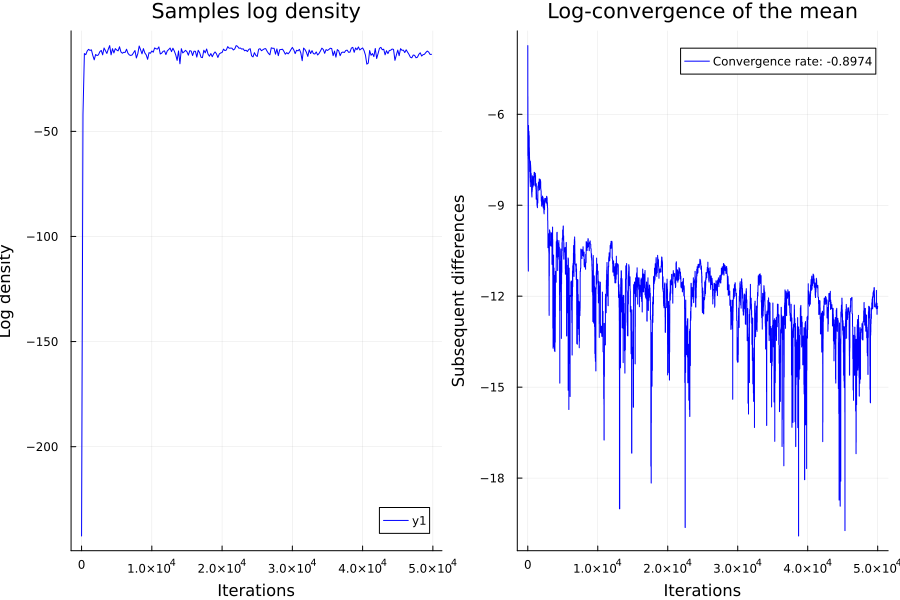

In [134]:
p01 = plot(1:200:50000,log.(probabilities[1:200:50000]),xlabel="Iterations",ylabel="Log density", title="Samples log density",color=:blue)
p02 = plot(log.(integ[1]),label="Convergence rate: -0.8974",title="Log-convergence of the mean",xlabel="Iterations",ylabel="Subsequent differences",
color=:blue)

plot(p01,p02,layout=(1,2),size=(900,600))
#savefig("5_TOMGRO_PEinSD_Convergence.png")

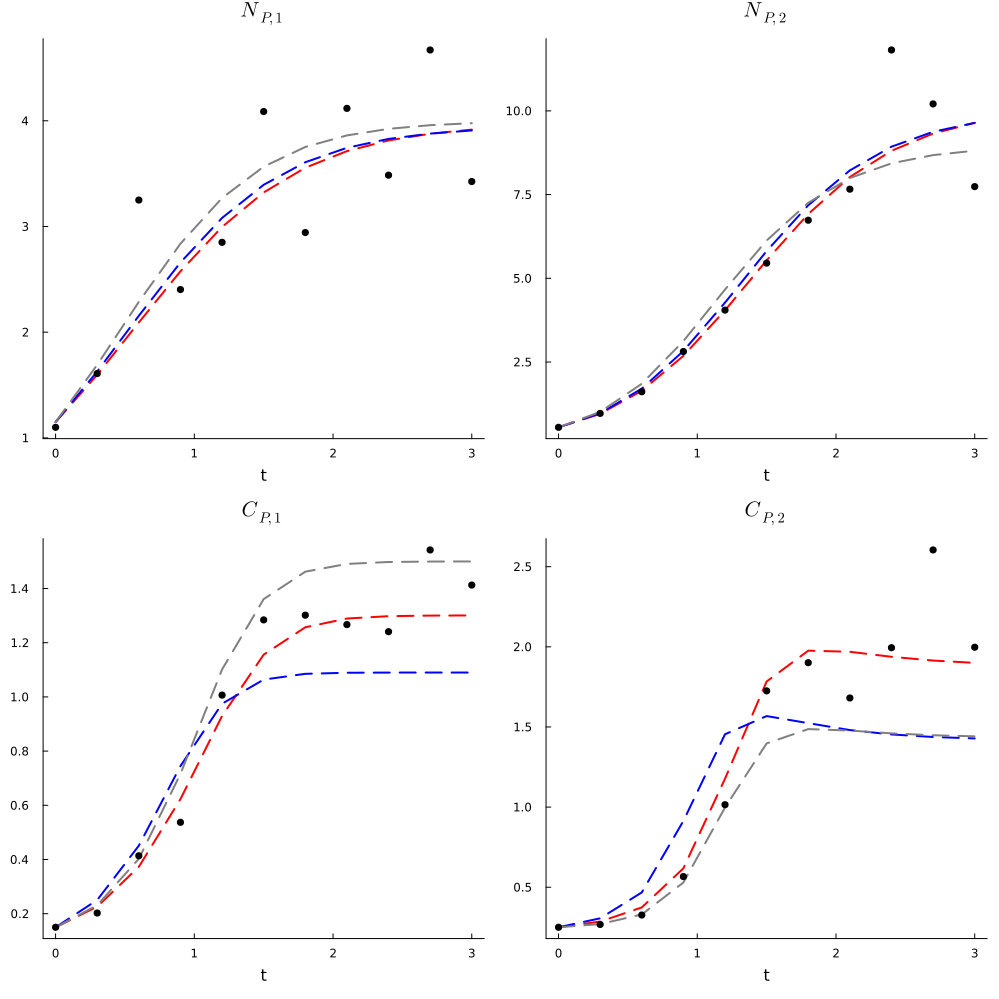

In [131]:
pdy1 = plot(Time,solve_system(MAP)[:,1],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$N_{P,1}$")
pdy1 = plot!(Time,solve_system(CM)[:,1],color=:blue,label="",lw=2,linestyle=:dash)
pdy1 = plot!(Time,solve_system([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])[:,1],color=:gray,label="",lw=2,linestyle=:dash)
pdy1 = scatter!(Time,Measures[:,1],color=:black,label="",lw=2,linestyle=:dash)

pdy2 = plot(Time,solve_system(MAP)[:,2],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$N_{P,2}$")
pdy2 = plot!(Time,solve_system(CM)[:,2],color=:blue,label="",lw=2,linestyle=:dash)
pdy2 = plot!(Time,solve_system([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])[:,2],color=:gray,label="",lw=2,linestyle=:dash)
pdy2 = scatter!(Time,Measures[:,2],color=:black,label="",lw=2,linestyle=:dash)

pdy3 = plot(Time,solve_system(MAP)[:,3],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$C_{P,1}$")
pdy3 = plot!(Time,solve_system(CM)[:,3],color=:blue,label="",lw=2,linestyle=:dash)
pdy3 = plot!(Time,solve_system([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])[:,3],color=:gray,label="",lw=2,linestyle=:dash)
pdy3 = scatter!(Time,Measures[:,3],color=:black,label="",lw=2,linestyle=:dash)

pdy4 = plot(Time,solve_system(MAP)[:,4],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$C_{P,2}$")
pdy4 = plot!(Time,solve_system(CM)[:,4],color=:blue,label="",lw=2,linestyle=:dash)
pdy4 = plot!(Time,solve_system([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])[:,4],color=:gray,label="",lw=2,linestyle=:dash)
pdy4 = scatter!(Time,Measures[:,4],color=:black,label="",lw=2,linestyle=:dash)


plot(pdy1,pdy2,pdy3,pdy4,layout=(2,2),size=(1000,1000))

#savefig("5_TOMGRO_PEinSD_Dynamics.png")

In [137]:
energy([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])

1.6420268966039415e-5

In [138]:
energy(MAP)/energy([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])

8.157281128454901

In [139]:
energy(CM)/energy([2.0, 0.5, 0.9, 0.2, 1.2, 0.8, 0.3, 0.6])

3.191539429322136